## SMAVA

Test exercise - Question 2 - Data investigation

Reduce the features used and try other models on whole of the dataset or sub-sets for each bank.

### Overview

#### Acceptance

Firstly, we analyze and decide that an acceptance tester for each bank can be 64% accurate using a radial SVM. 
A logistic model is only 60%. (Cross-validated within the train set.)

We note that this is with a reduced feature set: which is invariant across all banks - ie. the model enables each bank to decide with the same data on the customer. No conditioning on x6 or x7.

#### Interest Rate

There are two category fields, x6 and x7 which may help decide the interest rate offered by bank.
x6 is two-valued, x7 is 2000!

We should also revisit the correlations. x1 x10 and x4 are good for acceptance, but the discarded x values could correlate for interest rate.


In [1]:
## weaves
## smava

getwd()

## load in packages
library(tidyverse)
library(rpart.plot)

library(e1071)
library(MASS)
library(mlbench)
library(gbm)
library(kernlab)

## last loaded, first found methods
library(caret)

## implementation
library(doMC)

registerDoMC(cores = 4)

options(useFancyQuotes = TRUE)

[1] "/misc/build/0/pyeg0/caret/classr1"

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: rpart


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loaded gbm 2.1.5


Attaching package: 'kernlab'


The following object is masked from 'package:purrr':

    cross


The following object is masked from 'package:ggplot2':

    alpha


Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Loading required package: foreach


Attaching package: 'foreach'


The following objects are masked from 'package:purrr':

    accumulate, when


Loading required package:

In [2]:
load("bak/in/train.rdata")
load("bak/in/test.rdata")

train0 <- data.frame(train) # a local copy.

In [3]:
## Logistic regression using Narrow Feature set with conditioning on bank over all banks.

fit1 <- train(
  form = accepted ~ x1 + x10 + x4 + bank,
  data = train,
  trControl = trainControl(method = "cv", number = 5),
  method = "glm",
  family = "binomial"
)
fit1

Generalized Linear Model 

134969 samples
     4 predictor
     2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 107975, 107975, 107976, 107975, 107975 
Resampling results:

  Accuracy   Kappa    
  0.5991376  0.1969676


In [4]:
## Not very good. Let's try by bank.
## List the banks.
smava1 <- list()
smava1$banks <- unique(train[["bank"]])
length(smava1$banks)
smava1$banks

[1] 30

[1] B14 B4  B25 B3  B1  B8  B18 B21 B6  B15 B16 B2  B12 B27 B7  B30 B9  B22 B28
[20] B17 B26 B23 B11 B20 B19 B13 B29 B24 B5  B10
30 Levels: B1 B10 B11 B12 B13 B14 B15 B16 B17 B18 B19 B2 B20 B21 B22 ... B9

In [5]:
## Random choose a bank to look at
fidx <- function(N0, n=3) sample(1:N0, n, replace = FALSE)

t <- smava1$banks
tag <- t[fidx(length(t))]
tag <- tag[1:1]
tag
colnames(train)

[1] B28
30 Levels: B1 B10 B11 B12 B13 B14 B15 B16 B17 B18 B19 B2 B20 B21 B22 ... B9

[1] "customerNumber" "bank"           "x1"             "x2"            
 [5] "x3"             "x4"             "x5"             "x6"            
 [9] "x7"             "x8"             "x9"             "x10"           
[13] "accepted"       "interestRate"

In [6]:
cols <- colnames(train)
cols <- cols[grep('^x', cols)]
cols <- setdiff(cols, "x3")
cols <- c(cols, "accepted")
cols

[1] "x1"       "x2"       "x4"       "x5"       "x6"       "x7"      
 [7] "x8"       "x9"       "x10"      "accepted"

In [7]:
tag
outcomes <- train[ train$bank %in% tag, "accepted"]

train1 <- train[ train$bank %in% tag, cols]

train1$x2na <- 0
train1[is.na(train1$x2), "x2na"] <- 1

v0 <- train1[train1$x2 & train1$x2na == 0, "x2"]
v0 <- mean(v0[["x2"]])

train1[is.na(train1$x2), "x2"] <- v0

dim(train1)
head(train1)

# test1[ is.na(test1$x2), "x2" ] <- smava0$x2impute

[1] B28
30 Levels: B1 B10 B11 B12 B13 B14 B15 B16 B17 B18 B19 B2 B20 B21 B22 ... B9

[1] 4565   11

x1,x2,x4,x5,x6,x7,x8,x9,x10,accepted,x2na
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.5269400,5.2698227,1.9984622,7.3879101,FBW,T07WM,9.79505322,0.01833115,0.4486536,YES,0
0.1067951,0.1630893,0.9031934,-1.7503183,ACS,P4BYI,-0.15137745,0.31745683,0.2308991,NO,0
1.1514011,3.9997561,6.1126970,4.2751393,ACS,HIOCU,10.15535583,0.23951721,0.3105913,YES,0
0.8681548,1.3361652,11.7039072,7.5611098,FBW,YQQJ0,18.59876462,0.19383961,0.3472141,YES,0
0.1286235,2.3216856,0.4024352,-0.3378647,FBW,2OM2F,0.08924134,0.01909579,0.2631723,YES,0
0.3872526,0.5451423,9.5004654,2.7326351,ACS,JNC2G,11.15560232,0.31841992,0.3964121,YES,0


In [8]:
## Logistic fit for one bank is barely any better.
## Don't add to the formula x7 - no-converge

fit1x <- train(
  form = accepted ~ x1 + x10 + x4,
  data = train1,
  trControl = trainControl(method = "cv", number = 5),
  method = "glm",
  family = "binomial"
)
fit1x

Generalized Linear Model 

4565 samples
   3 predictor
   2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3652, 3653, 3652, 3652, 3651 
Resampling results:

  Accuracy   Kappa    
  0.5958351  0.1755903


### Note

Tried a few formulae, no improvement with x2. 
No real improvement even if limited to just one bank.

Try some SVM classifiers - these only converge on small data-sets. There are a number of 

The pair plots, suggest that radials can be good method

In [9]:
## Formally constrain to the Narrow Feature set
cols <- c("x1", "x10", "x4", "accepted")
df0 <- train1[,cols]

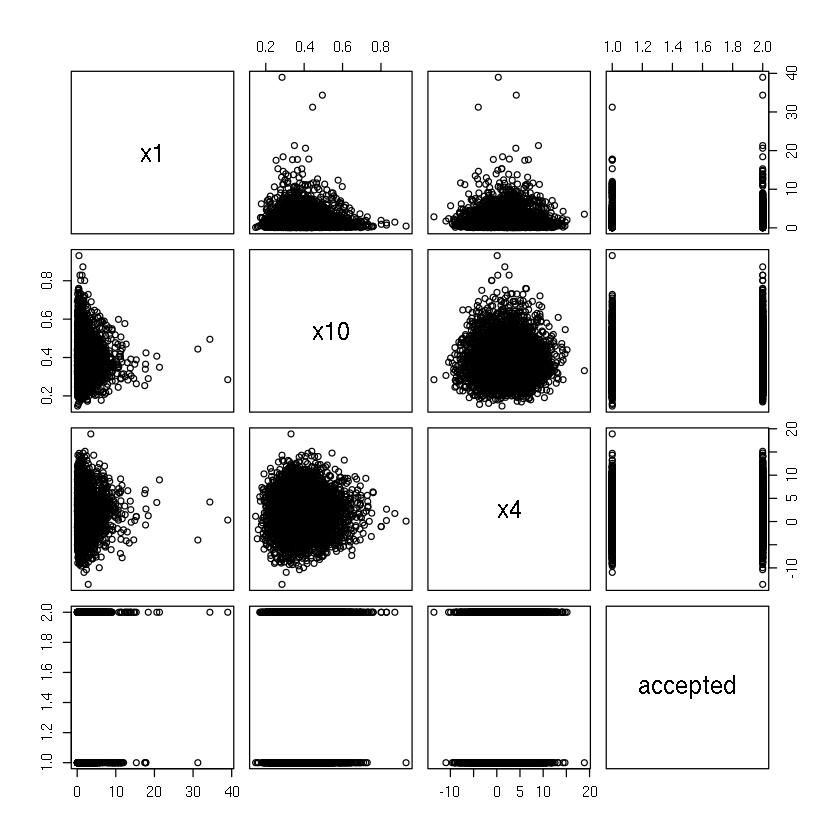

In [10]:
plot(df0)

In [11]:
## Heuristically try other models
method <- 'svmLinear2'
method <- 'svmPoly'

## all these give 64%
method <- 'svmRadial'
method <- 'svmRadialSigma'
method <- 'svmRadialCost'

In [12]:
## By bank - acceptance using Narrow Feature set

fit1x <- train(
  form = accepted ~ .,
  data = df0,
  trControl = trainControl(method = "cv", number = 5),
  method = method    
)
fit1x

Support Vector Machines with Radial Basis Function Kernel 

4565 samples
   3 predictor
   2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3652, 3652, 3652, 3652, 3652 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.6547645  0.2994917
  0.50  0.6543264  0.2987547
  1.00  0.6541073  0.2982543

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 0.25.

In [13]:
trainPred <- predict(fit1x, df0)
# postResample(testPred, testClass)

conf0 <- confusionMatrix(trainPred, df0[["accepted"]], positive = "YES")
conf0

Confusion Matrix and Statistics

          Reference
Prediction   NO  YES
       NO  1860  960
       YES  564 1181
                                          
               Accuracy : 0.6662          
                 95% CI : (0.6523, 0.6798)
    No Information Rate : 0.531           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3224          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5516          
            Specificity : 0.7673          
         Pos Pred Value : 0.6768          
         Neg Pred Value : 0.6596          
             Prevalence : 0.4690          
         Detection Rate : 0.2587          
   Detection Prevalence : 0.3823          
      Balanced Accuracy : 0.6595          
                                          
       'Positive' Class : YES             
                        

### Recap and Plan: customer to acceptances at each bank

Model with predictor trained by bank using 'svmRadialCost' gets 64% on the training set - cross-validated.
using just the fields: "x1", "x10", "x4" - the Narrow Feature Set

So for each customer, we want to know what banks might accept them. 

A customer gets a different set of values from each bank, but not on the features of the Narrow Feature set.
So the customer record can be duplicated for each bank. A prediction made with that bank's predictor for all customers.

That would produce the banks.rdata results without any methodological issues, but that is unordered.

### Plan: bank ordering by interest rate

We then have to order the bank choice by interest rate given. We should train a second regression predictor, for all accepted customers at a bank and the interest they receive. And we have to consider if x6 and x7 are correlated to interest rate.

In [14]:
## Visual - check the feature relationships - customer is constant across bank. Interest rate varies.
cols <- unique(c(cols, "x1", "x4", "x10"))
df2 <- train[order(train$customerNumber, train$bank), c("customerNumber", "accepted", "bank", c(cols, "x6", "x7"), "x2", "interestRate")]
head(df2, n=50)

customerNumber,accepted,bank,x1,x10,x4,accepted,x6,x7,x2,interestRate
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
2,YES,B14,0.9954692,0.4061550,2.3327741,YES,ACS,T3Y63,3.6887724,3.315310
2,YES,B17,0.9954692,0.4061550,2.3327741,YES,ACS,T3Y63,3.6887724,5.746954
2,NO,B22,0.9954692,0.4061550,2.3327741,NO,ACS,T3Y63,3.6887724,NA
2,NO,B28,0.9954692,0.4061550,2.3327741,NO,ACS,T3Y63,3.6887724,NA
2,YES,B29,0.9954692,0.4061550,2.3327741,YES,ACS,T3Y63,3.6887724,4.248454
2,YES,B30,0.9954692,0.4061550,2.3327741,YES,ACS,T3Y63,3.6887724,3.542020
3,YES,B1,0.9127837,0.3381793,0.3006364,YES,ACS,HG2BV,18.6973056,2.030626
3,NO,B10,0.9127837,0.3381793,0.3006364,NO,ACS,HG2BV,18.6973056,NA
3,YES,B18,0.9127837,0.3381793,0.3006364,YES,ACS,HG2BV,18.6973056,2.630021


In [15]:
## Logistic regression using Narrow Feature set with conditioning on bank over all banks.

fit1 <- train(
  form = accepted ~ x1 + x10 + x4,
  data = train,
  trControl = trainControl(method = "cv", number = 5),
  method = "glm",
  family = "binomial"
)
fit1

Generalized Linear Model 

134969 samples
     3 predictor
     2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 107976, 107975, 107975, 107975, 107975 
Resampling results:

  Accuracy   Kappa    
  0.5979818  0.1946316


In [ ]:
## An interest rate predictor would be like this. 
df3 <- df2[df2$accepted == "YES", c("bank", "interestRate", "customerNumber", "x7", "x6", cols)]
df3[order(-df3$interestRate, df3$bank),]

## Built for each bank it would take the x values, returning interestRate for all 

The customer numbers at all banks, so a weighted regression on x values to interestRate 
with a two-ply tree on x6 and x7.
Banks are 30 in number so same number of predictors. Try a global regression predictor using x6, x7 and xvalues

In [17]:
# Look at interest rates for one bank.
df4 <- train[train$bank == "B1" & train$accepted == "YES", setdiff(colnames(train), c("customerNumber", "bank", "accepted", "x3", "x6", "x7"))]

x2bar <- mean(df4$x2, trim=0, na.rm=TRUE)
x2bar
df4[is.na(df4$x2), "x2"] <- x2bar

[1] 7.840669

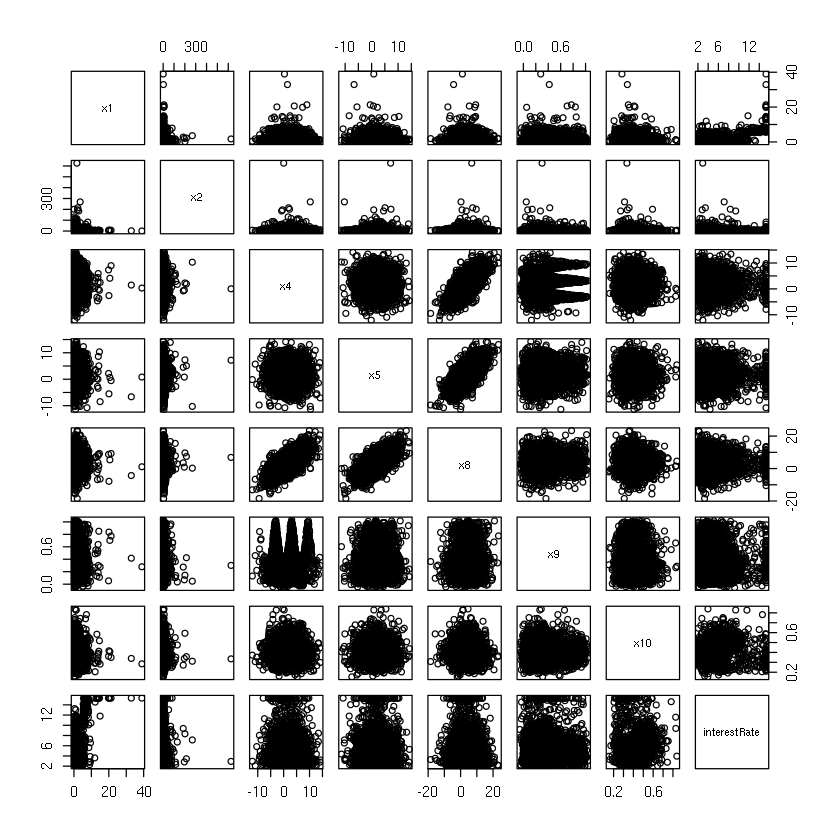

In [18]:
plot(df4)

In [19]:
## All over looks of business
summary(df4)

       x1                x2                 x4                 x5          
 Min.   : 0.0286   Min.   :  0.0173   Min.   :-12.0946   Min.   :-11.3811  
 1st Qu.: 0.4629   1st Qu.:  1.4982   1st Qu.: -0.8995   1st Qu.: -0.6436  
 Median : 0.9130   Median :  5.9886   Median :  1.9487   Median :  1.9968  
 Mean   : 1.6440   Mean   :  7.8407   Mean   :  1.8825   Mean   :  1.9608  
 3rd Qu.: 1.8058   3rd Qu.:  7.8407   3rd Qu.:  4.6628   3rd Qu.:  4.5150  
 Max.   :38.9767   Max.   :625.8334   Max.   : 14.1252   Max.   : 14.2650  
       x8                 x9                x10          interestRate   
 Min.   :-18.4743   Min.   :-0.05672   Min.   :0.1533   Min.   : 2.031  
 1st Qu.: -0.1021   1st Qu.: 0.18800   1st Qu.:0.3336   1st Qu.: 3.056  
 Median :  3.9522   Median : 0.32728   Median :0.3889   Median : 4.558  
 Mean   :  3.8526   Mean   : 0.36448   Mean   :0.4008   Mean   : 5.327  
 3rd Qu.:  7.7896   3rd Qu.: 0.48736   3rd Qu.:0.4568   3rd Qu.: 6.696  
 Max.   : 23.3827   Max.   : 1

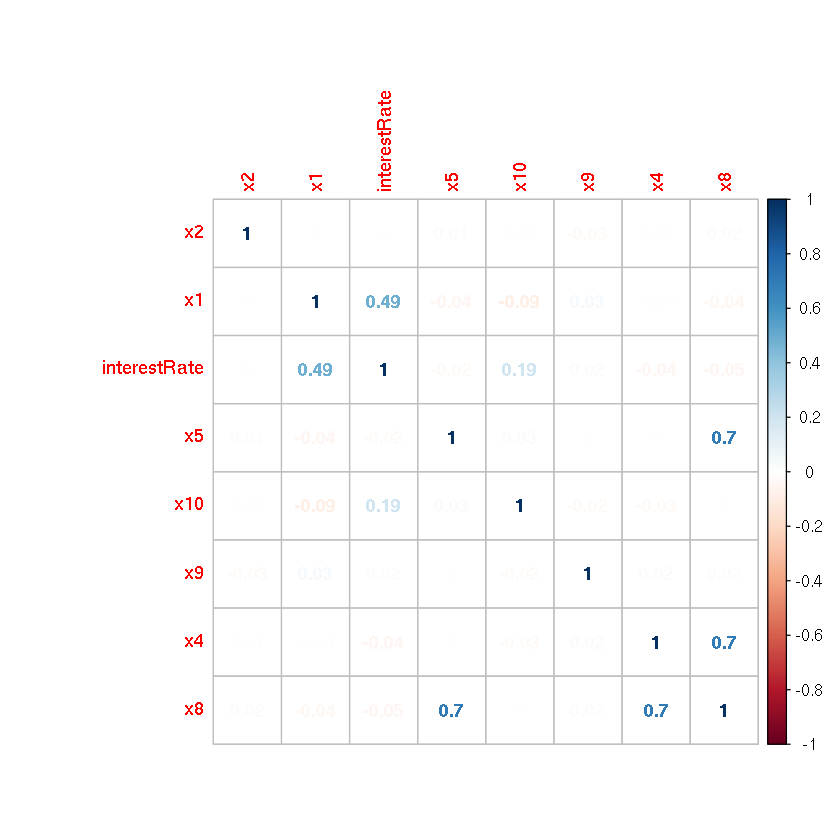

In [20]:
## Nothing new on corrrelations

c0 <- cor(df4)
corrplot::corrplot(c0, method="number", order="hclust")

In [21]:
## Look for a regression and check Rsquared

regressControl  <- trainControl(method="repeatedcv",
                    number = 4,
                    repeats = 5
                    ) 

## R^2 of only 0.3 is not good enough, with x6 is not better.
regress <- train(interestRate ~ .,
           data = df4,
           method  = "lm",
           trControl = regressControl,
           tuneGrid  = expand.grid(intercept = FALSE))
regress

Linear Regression 

2388 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (4 fold, repeated 5 times) 
Summary of sample sizes: 1790, 1791, 1791, 1792, 1792, 1791, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  2.552006  0.286672  1.950262

Tuning parameter 'intercept' was held constant at a value of FALSE

In [33]:
## Let's overfit with a multi-layer perceptron and see if I can use x6 and x7.
## Regression model two inaccurate. A simple multi-layer perceptron - a look up table almost.

fControl  <- trainControl(method="repeatedcv",
                    number = 4,
                    repeats = 5
                    )
method = 'mlp'

mi <- getModelInfo(model = method, regex = FALSE)[[1]]
p0 <- data.frame(mi$parameters)
p0

In [34]:
data.frame(interaction.depth = c(1, 5, 9))

interaction.depth
<dbl>
1
5
9


In [43]:
## "x6", "x7"
df4 <- train[train$bank == "B1" & train$accepted == "YES", setdiff(colnames(train), c("customerNumber", "bank", "accepted", "x3"))]

x2bar <- mean(df4$x2, trim=0, na.rm=TRUE)
x2bar
df4[is.na(df4$x2), "x2"] <- x2bar
head(df4)

[1] 7.840669

x1,x2,x4,x5,x6,x7,x8,x9,x10,interestRate
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0.3300401,8.5267630,1.313198,3.667541,FBW,IEWGU,5.852168,0.41570813,0.3843245,9.850295
2.1521036,0.4313750,3.200129,-3.533792,ACS,FEPNE,-1.256922,0.34845861,0.3447617,7.276713
1.1111884,1.2758177,6.235830,2.992320,ACS,XZ4HK,9.648096,0.04467801,0.4441911,5.152014
1.4217174,0.5527955,2.813481,-1.588118,ACS,WXATN,1.033609,0.94170372,0.5526227,10.339212
0.1884537,0.2928787,4.571422,1.942665,FBW,30JI7,7.540428,0.09108014,0.4467335,5.855896
0.9992217,0.3427903,-1.157065,9.513477,FBW,YVNYM,8.125038,0.35138642,0.4740662,7.569349


In [44]:
## Try 
## tuneGrid  = expand.grid(intercept = FALSE)
## 0.111 Rsqr ; 
fit0 <- train(interestRate ~ .,
           data = df4,
           method  = method,
           trControl = fControl, tuneGrid = data.frame(size=c(11)))
fit0

Multi-Layer Perceptron 

2388 samples
   9 predictor

No pre-processing
Resampling: Cross-Validated (4 fold, repeated 5 times) 
Summary of sample sizes: 1791, 1791, 1791, 1791, 1791, 1791, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  3.039081  0.1084812  2.368587

Tuning parameter 'size' was held constant at a value of 11

In [38]:
head(df4)

x1,x2,x4,x5,x8,x9,x10,interestRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3300401,8.5267630,1.313198,3.667541,5.852168,0.41570813,0.3843245,9.850295
2.1521036,0.4313750,3.200129,-3.533792,-1.256922,0.34845861,0.3447617,7.276713
1.1111884,1.2758177,6.235830,2.992320,9.648096,0.04467801,0.4441911,5.152014
1.4217174,0.5527955,2.813481,-1.588118,1.033609,0.94170372,0.5526227,10.339212
0.1884537,0.2928787,4.571422,1.942665,7.540428,0.09108014,0.4467335,5.855896
0.9992217,0.3427903,-1.157065,9.513477,8.125038,0.35138642,0.4740662,7.569349


In [25]:
?caret::train

train {caret},R Documentation
x,"For the default method, x is an object where samples are in rows and features are in columns. This could be a simple matrix, data frame or other type (e.g. sparse matrix) but must have column names (see Details below). Preprocessing using the preProcess argument only supports matrices or data frames. When using the recipe method, x should be an unprepared recipe object that describes the model terms (i.e. outcome, predictors, etc.) as well as any pre-processing that should be done to the data. This is an alternative approach to specifying the model. Note that, when using the recipe method, any arguments passed to preProcess will be ignored. See the links and example below for more details using recipes."
...,Arguments passed to the classification or regression routine (such as randomForest). Errors will occur if values for tuning parameters are passed here.
y,A numeric or factor vector containing the outcome for each sample.
method,A string specifying which classification or regression model to use. Possible values are found using names(getModelInfo()). See http://topepo.github.io/caret/train-models-by-tag.html. A list of functions can also be passed for a custom model function. See http://topepo.github.io/caret/using-your-own-model-in-train.html for details.
preProcess,"A string vector that defines a pre-processing of the predictor data. Current possibilities are ""BoxCox"", ""YeoJohnson"", ""expoTrans"", ""center"", ""scale"", ""range"", ""knnImpute"", ""bagImpute"", ""medianImpute"", ""pca"", ""ica"" and ""spatialSign"". The default is no pre-processing. See preProcess and trainControl on the procedures and how to adjust them. Pre-processing code is only designed to work when x is a simple matrix or data frame."
weights,A numeric vector of case weights. This argument will only affect models that allow case weights.
metric,"A string that specifies what summary metric will be used to select the optimal model. By default, possible values are ""RMSE"" and ""Rsquared"" for regression and ""Accuracy"" and ""Kappa"" for classification. If custom performance metrics are used (via the summaryFunction argument in trainControl, the value of metric should match one of the arguments. If it does not, a warning is issued and the first metric given by the summaryFunction is used. (NOTE: If given, this argument must be named.)"
maximize,A logical: should the metric be maximized or minimized?
trControl,"A list of values that define how this function acts. See trainControl and http://topepo.github.io/caret/using-your-own-model-in-train.html. (NOTE: If given, this argument must be named.)"
tuneGrid,"A data frame with possible tuning values. The columns are named the same as the tuning parameters. Use getModelInfo to get a list of tuning parameters for each model or see http://topepo.github.io/caret/available-models.html. (NOTE: If given, this argument must be named.)"


## Note

There's a lot of variation at the bank for the interest rate. It may be that one of the factor fields is a product.
The codes in x6 and x7 might be multi-modal with respective to the x6 (or x7).

So I should check the pair-plot with interestRate.

In [ ]:
## check x6 and x7 - chi-sq by eye
## No clear classification on interestRate

## Note
## One day, I'll learn dylpr
tag <- "x6"
tag1 <- "ACS"

tag <- "x7"
tags <- unique(train[[tag]])
length(tags)
tag1<- tags[2]

cols <- c("x10", "bank", "x5", tag, "interestRate")
df3 <- train[!is.na(train$interestRate), cols]
df3 <- df3[ order(df3$bank, df3[[tag]]), cols]
# lapply(df3[ df3$bank == "B1",], summary)

lapply(df3[ df3[[tag]] == tag1 & df3$bank == "B1",], summary)
lapply(df3[ df3[[tag]] != tag1 & df3$bank == "B1",], summary)

## x7 product codes

Is the x7 a product field that is common to all banks?

It looks like bank B9 has never offered a particular x7

In [ ]:
x7s <- c("69TO8", "157H7")
x7s0 <- unique(train[["x7"]])
length(x7s0)
df0 <- data.frame(with(train, table(x7, x6)))
df0[order(-df0$Freq),]
df0 <- data.frame(with(train, table(x7, bank)))
df0[order(-df0$Freq),]

In [ ]:
summary(train$x6)
summary(train$x7)
with(train, table(x6, x7))

In [ ]:
## No obvious splits?
cp0 <- 0.005
method0 <- "class" # anova
method0 <- "anova" # anova
x7s
tag <- "WXATN"
tag <- x7s[1]
df0 <- train[train$x7 == tag, ]
tag
tree <- rpart(interestRate ~ bank + x7 + x6, data=df0, cp=cp0, method = method0)
                         # cp=.02 because want small tree for demo

rpart.plot(tree)

## x6 FBW and ACS

In [ ]:
with(warpbreaks, table(wool, tension))

In [ ]:
with(train, table(bank, x7))

In [ ]:
## Interesting products
## Trying to see if any relationship between x7 and interestRate. Very sparse data, two codes have more than 20 per bank.
## Possibly a standard product?
x7s <- c("69TO8", "157H7")

In [ ]:
df0 <- train[!is.na(train$interestRate) & train$x7 %in% x7s, c("bank", "interestRate", "x7")]

f <- function(x) list(summary(x))

by_cyl <- df0 %>% group_by(bank) %>%  summarise(
  disp = f(interestRate),
)
by_cyl

by_cyl <- df0 %>% group_by(x7) %>%  summarise(
  disp = f(interestRate),
)
by_cyl


In [ ]:
summary(1:10)